In [1]:
pip install torchaudio librosa soundfile

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
import torch
import torchaudio
import librosa
import soundfile as sf
import numpy as np

# Загрузка аудио (добавим искусственный шум)
audio, sr = librosa.load(librosa.ex('trumpet'), sr=16000)
noise = 0.05 * np.random.randn(len(audio))  # Гауссов шум
noisy_audio = audio + noise

# Сохраним шумное аудио
sf.write('noisy.wav', noisy_audio, sr)

In [3]:
class AudioDenoiser(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv1d(1, 16, kernel_size=32, stride=8),
            torch.nn.ReLU(),
            torch.nn.Conv1d(16, 32, kernel_size=16, stride=4),
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.ConvTranspose1d(32, 16, kernel_size=16, stride=4),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose1d(16, 1, kernel_size=32, stride=8),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = AudioDenoiser()

In [4]:
# Преобразуем данные в тензоры
noisy_tensor = torch.FloatTensor(noisy_audio).unsqueeze(0).unsqueeze(0)  # [1, 1, T]
clean_tensor = torch.FloatTensor(audio).unsqueeze(0).unsqueeze(0)

# Loss и оптимизатор
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Процесс обучения
for epoch in range(100):
    optimizer.zero_grad()
    output = model(noisy_tensor)
    loss = criterion(output, clean_tensor)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1, 1, 85335])) that is different to the input size (torch.Size([1, 1, 85304])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (85304) must match the size of tensor b (85335) at non-singleton dimension 2

In [ ]:
with torch.no_grad():
    denoised = model(noisy_tensor)

# Сохраним результат
denoised_audio = denoised.squeeze().numpy()
sf.write('denoised.wav', denoised_audio, sr)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(audio)
plt.title('Original Audio')

plt.subplot(3, 1, 2)
plt.plot(noisy_audio)
plt.title('Noisy Audio')

plt.subplot(3, 1, 3)
plt.plot(denoised_audio)
plt.title('Denoised Audio')
plt.tight_layout()
plt.show()

Input size: torch.Size([1, 1, 79992])
Clean audio size: torch.Size([1, 1, 79992])
Epoch 0, Loss: 0.0076
Epoch 10, Loss: 0.0061
Epoch 20, Loss: 0.0055
Epoch 30, Loss: 0.0045
Epoch 40, Loss: 0.0034
Epoch 50, Loss: 0.0023
Epoch 60, Loss: 0.0017
Epoch 70, Loss: 0.0013
Epoch 80, Loss: 0.0010
Epoch 90, Loss: 0.0008


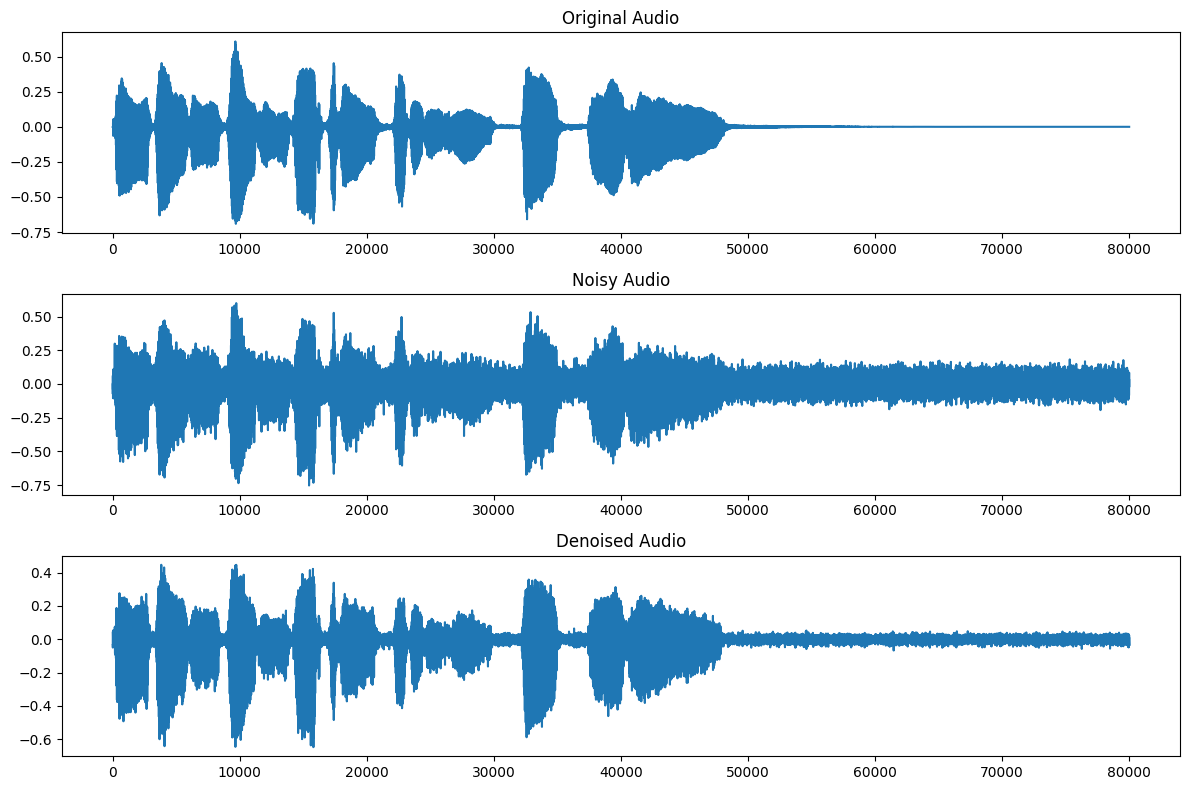

In [6]:
import torch
import torch.nn as nn
import torchaudio
import librosa
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt

# 1. Загрузка и подготовка данных
audio, sr = librosa.load(librosa.ex('trumpet'), sr=16000)
audio = audio[:79992]  # Фиксируем длину для стабильности
noise = 0.05 * np.random.randn(len(audio))
noisy_audio = audio + noise

# 2. Определение модели с правильными размерами
class AudioDenoiser(nn.Module):
    def __init__(self):
        super().__init__()
        # Энкодер с padding для сохранения размеров
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=32, stride=8, padding=16),
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=16, stride=4, padding=8),
        )
        # Декодер с соответствующими параметрами
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(32, 16, kernel_size=16, stride=4, padding=8, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose1d(16, 1, kernel_size=32, stride=8, padding=16, output_padding=0),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = AudioDenoiser()

# 3. Подготовка данных с правильными размерами
noisy_tensor = torch.FloatTensor(noisy_audio).unsqueeze(0).unsqueeze(0)  # [1, 1, T]
clean_tensor = torch.FloatTensor(audio).unsqueeze(0).unsqueeze(0)

# Проверка размерностей
print("Input size:", noisy_tensor.shape)
print("Clean audio size:", clean_tensor.shape)

# 4. Обучение модели
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(100):
    optimizer.zero_grad()
    output = model(noisy_tensor)

    # Обрезаем выход до размера целевого аудио
    output = output[:, :, :clean_tensor.shape[2]]

    loss = criterion(output, clean_tensor)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

# 5. Применение модели
with torch.no_grad():
    denoised = model(noisy_tensor)
    denoised = denoised[:, :, :len(audio)]  # Обрезаем до нужной длины

# 6. Сохранение и визуализация
denoised_audio = denoised.squeeze().numpy()
sf.write('noisy.wav', noisy_audio, sr)
sf.write('denoised.wav', denoised_audio, sr)

plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(audio)
plt.title('Original Audio')

plt.subplot(3, 1, 2)
plt.plot(noisy_audio)
plt.title('Noisy Audio')

plt.subplot(3, 1, 3)
plt.plot(denoised_audio)
plt.title('Denoised Audio')
plt.tight_layout()
plt.show()